In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
import functions

In [23]:
import importlib

importlib.reload(functions)

<module 'functions' from 'c:\\Users\\balsevt\\python\\m3s4\\functions.py'>

In [2]:
df_app = pd.read_parquet(r"data\train\df_app.parquet", engine="pyarrow")
df_bur = pd.read_parquet(r"data\train\df_bur.parquet", engine="pyarrow")
df_bur_bal = pd.read_parquet(r"data\train\df_bur_bal.parquet", engine="pyarrow")
df_prev_app = pd.read_parquet(r"data\train\df_prev_app.parquet", engine="pyarrow")
df_cash = pd.read_parquet(r"data\train\df_cash.parquet", engine="pyarrow")
df_inst = pd.read_parquet(r"data\train\df_inst.parquet", engine="pyarrow")
df_cred = pd.read_parquet(r"data\train\df_cred.parquet", engine="pyarrow")

In [3]:
curr_dfs = [df_app, df_bur, df_prev_app, df_cash, df_inst, df_cred]
bur_dfs = [df_bur, df_bur_bal]
prev_dfs = [df_prev_app, df_cash, df_inst, df_cred]

for df in curr_dfs:
    functions.check_df_nulls(df["SK_ID_CURR"])

for df in bur_dfs:
    functions.check_df_nulls(df["SK_ID_BUREAU"])

for df in prev_dfs:
    functions.check_df_nulls(df["SK_ID_PREV"])

All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok
All ok


### Aggregating Bureau Balance Table

#### Test df_bur_bal aggregations

We would need: last and max status of a loan as well as mean, std of the loan while it was not yet closed

In [8]:
df_bur_bal["STATUS"].unique()

array(['C', '0', 'X', '1', '2', '5', '4', '3'], dtype=object)

In [9]:
data = {
    "SK_ID_BUREAU": [1, 1, 1, 1, 1, 1, 2, 2, 2, 3],
    "MONTHS_BALANCE": [0, -1, -2, -3, -4, -5, 0, -1, -2, 0],
    "STATUS": ["C", "0", "1", "1", "1", "X", "1", "2", "3", "C"],
}

test = pd.DataFrame(data)

In [10]:
functions.aggregate_bur_bal(test)

,SK_ID_BUREAU,STATUS_last,STATUS_median,STATUS_mean,STATUS_std,STATUS_max
0,1,-1.0,1.0,0.75,0.5,1.0
1,2,1.0,2.0,2.00,1.0,3.0
2,3,-1.0,NaN,NaN,NaN,NaN


In [ ]:
df_selected_few = df_app.sample(20, random_state=42)

curr_ids = [334358]

df_bur_filtered = df_bur[df_bur["SK_ID_CURR"].isin(curr_ids)]
bureau_ids = df_bur_filtered["SK_ID_BUREAU"]

df_bur_bal_filtered = df_bur_bal[df_bur_bal["SK_ID_BUREAU"].isin(bureau_ids)]

In [11]:
functions.aggregate_bur_bal(df_bur_bal_filtered)

,SK_ID_BUREAU,STATUS_last,STATUS_median,STATUS_mean,STATUS_std,STATUS_max
0,5501454,-1.0,0.0,0.000000,0.000000,0.0
1,5501456,-1.0,0.0,0.000000,0.000000,0.0
2,5501455,NaN,0.0,0.153846,0.375534,1.0


#### Aggregate the Table

In [3]:
df_bur_bal_agg = functions.aggregate_bur_bal(df_bur_bal)

#### Explore Bureau Balance Aggregations

In [13]:
df_bur_bal_agg.describe()

,SK_ID_BUREAU,STATUS_last,STATUS_median,STATUS_mean,STATUS_std,STATUS_max
count,4.953830e+05,267465.000000,433689.000000,433689.000000,409065.000000,433689.000000
mean,5.974812e+06,-0.651786,0.032552,0.052616,0.076421,0.202675
std,5.171548e+05,0.590703,0.315570,0.280736,0.236631,0.615389
min,5.008804e+06,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.576562e+06,-1.000000,0.000000,0.000000,0.000000,0.000000
50%,6.023622e+06,-1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.398064e+06,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.842888e+06,5.000000,5.000000,5.000000,3.535534,5.000000


STATUS_last
False    0.539916
True     0.460084
Name: proportion, dtype: float64

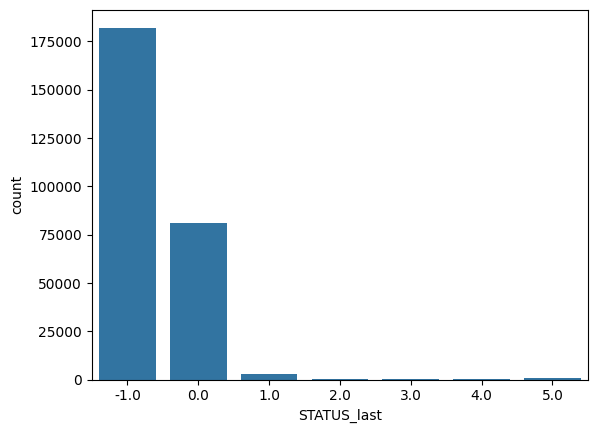

In [45]:
sns.countplot(df_bur_bal_agg, x="STATUS_last")
df_bur_bal_agg["STATUS_last"].isna().value_counts(normalize=True)

STATUS_mean
False    0.875462
True     0.124538
Name: proportion, dtype: float64

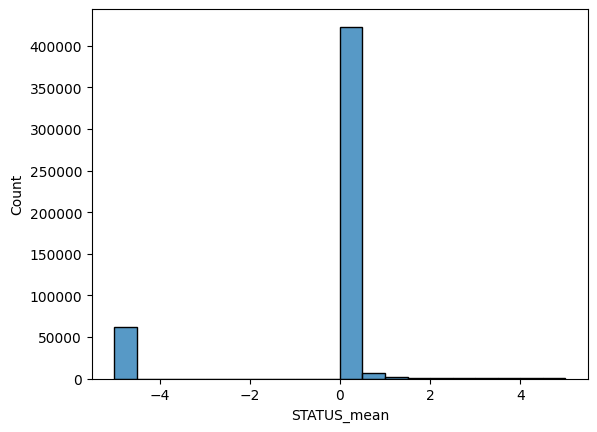

In [47]:
sns.histplot(df_bur_bal_agg.fillna(-5), x="STATUS_mean")
df_bur_bal_agg["STATUS_mean"].isna().value_counts(normalize=True)

STATUS_max
False    0.875462
True     0.124538
Name: proportion, dtype: float64

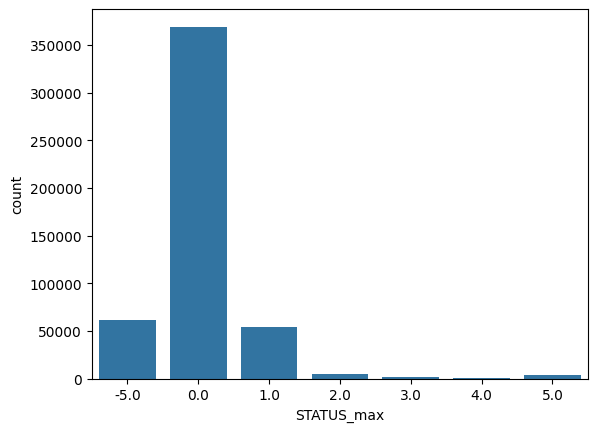

In [48]:
sns.countplot(df_bur_bal_agg.fillna(-5), x="STATUS_max")
df_bur_bal_agg["STATUS_max"].isna().value_counts(normalize=True)

### Aggregating Bureau Table

merge Bureau balance aggregations onto Bureau table

In [4]:
df = df_bur.merge(df_bur_bal_agg, how="outer", on="SK_ID_BUREAU")

#### Explore the Table's Features

In [20]:
df_filtered = df[df["SK_ID_CURR"].isin(curr_ids)]
df_filtered.iloc[:, :8]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT
604825,334358,5501454,Closed,currency 1,-1696,0,-1359.0,-1359.0
604826,334358,5501455,Closed,currency 1,-2509,0,-2204.0,-2201.0
604827,334358,5501456,Closed,currency 1,-342,0,-69.0,-69.0


In [52]:
df_filtered.iloc[:, 8:14]

,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
604825,NaN,0,131706.0,0.0,0.0,0.0
604826,0.0,0,41067.0,NaN,NaN,0.0
604827,0.0,0,99000.0,0.0,0.0,0.0


In [53]:
df_filtered.iloc[:, 14:]

,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,STATUS_last,STATUS_median,STATUS_mean,STATUS_std,STATUS_max
604825,Consumer credit,-1357,NaN,-1.0,0.0,0.000000,0.000000,0.0
604826,Consumer credit,-2197,30055.5,NaN,0.0,0.153846,0.375534,1.0
604827,Consumer credit,-67,NaN,-1.0,0.0,0.000000,0.000000,0.0


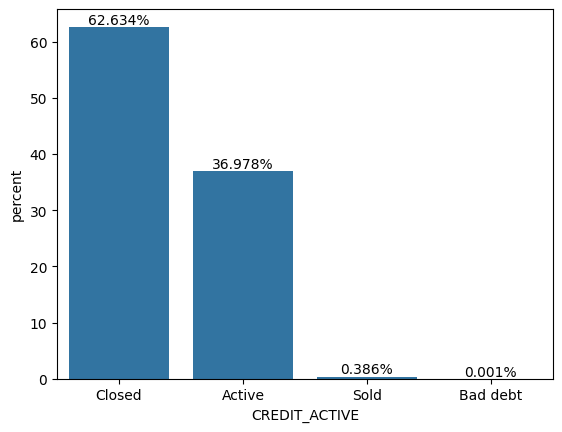

In [8]:
sns.countplot(df.fillna("NONE"), x="CREDIT_ACTIVE", stat="percent")
functions.add_labels(fmt="%2.3f%%")

This should provide the same info as our aggregate STATUS_last. It provides additional info and also we seem to be lacking the aggregate quite frequently. We should consider dropping our STATUS_last aggregate and use this instead. To aggregate CREDIT_ACTIVE, we would probably want to have the counts of categories.

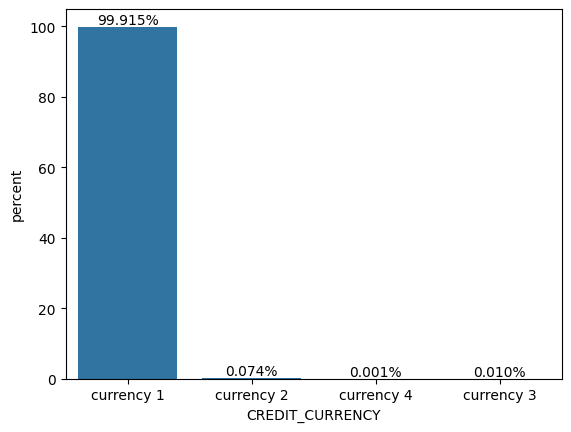

In [33]:
sns.countplot(df.fillna("NONE"), x="CREDIT_CURRENCY", stat="percent")
functions.add_labels(fmt="%2.3f%%")

almost everyone is using currency 1, may only consider binary "uses other currencies". we'll use unique count to estimate this.

DAYS_CREDIT
False    1.0
Name: proportion, dtype: float64

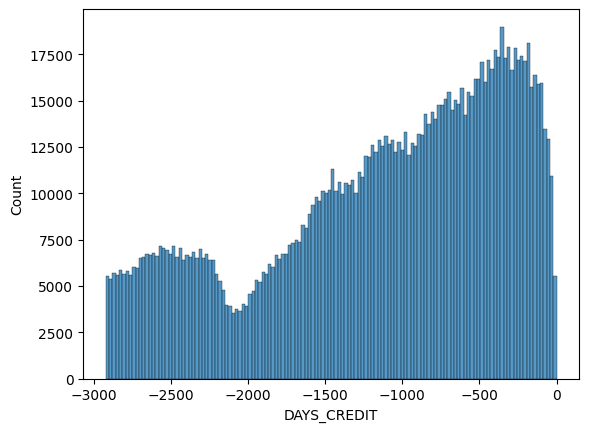

In [33]:
sns.histplot(df["DAYS_CREDIT"])
df["DAYS_CREDIT"].isna().value_counts(normalize=True)

Min, mean

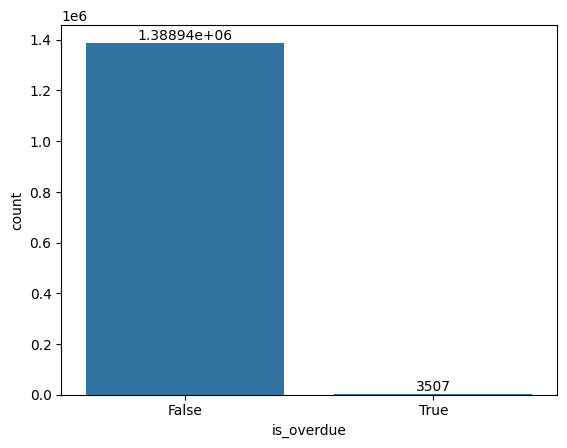

In [26]:
df_overdue = df[["CREDIT_DAY_OVERDUE"]].copy()
df_overdue["is_overdue"] = df_overdue["CREDIT_DAY_OVERDUE"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue")
functions.add_labels()

Very little loans seem to be overdue. Lets aggregate this column into "has_overdue"

DAYS_CREDIT_ENDDATE
False    0.939135
True     0.060865
Name: proportion, dtype: float64

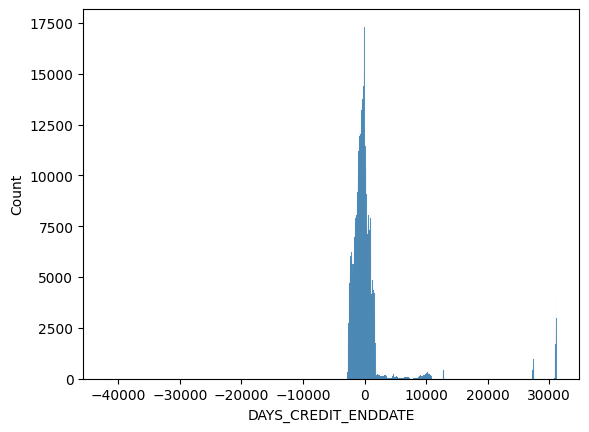

In [32]:
sns.histplot(df["DAYS_CREDIT_ENDDATE"])
df["DAYS_CREDIT_ENDDATE"].isna().value_counts(normalize=True)

for those loans that are not closed, calculate max, mean

DAYS_ENDDATE_FACT
False    0.628328
True     0.371672
Name: proportion, dtype: float64

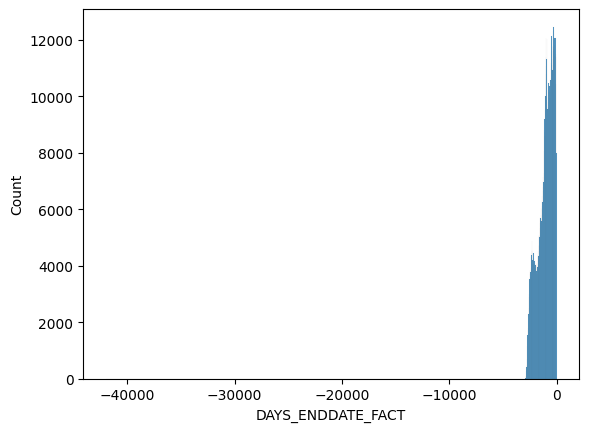

In [34]:
sns.histplot(df["DAYS_ENDDATE_FACT"])
df["DAYS_ENDDATE_FACT"].isna().value_counts(normalize=True)

will not be used

AMT_CREDIT_MAX_OVERDUE
True     0.647498
False    0.352502
Name: proportion, dtype: float64

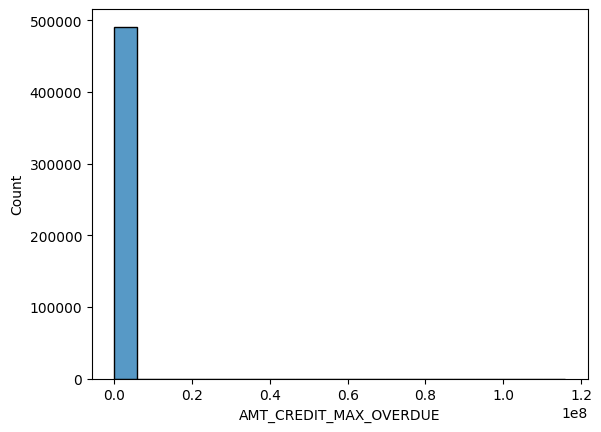

In [35]:
sns.histplot(df["AMT_CREDIT_MAX_OVERDUE"])
df["AMT_CREDIT_MAX_OVERDUE"].isna().value_counts(normalize=True)

drop, already covered and many nans

CNT_CREDIT_PROLONG
False    1.0
Name: proportion, dtype: float64

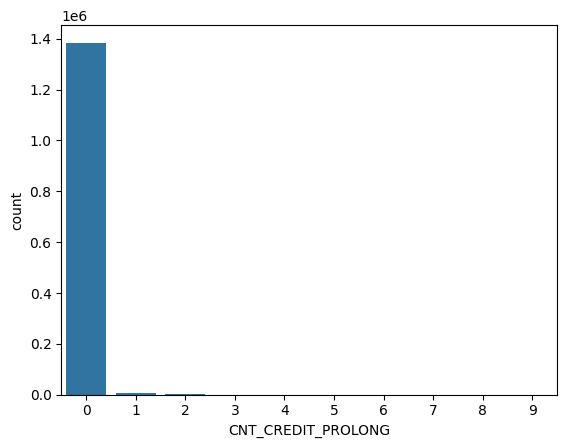

In [36]:
sns.countplot(df, x="CNT_CREDIT_PROLONG")
df["CNT_CREDIT_PROLONG"].isna().value_counts(normalize=True)

aggregate into binary "has_prolonged"

All AMT columns to be aggregated into max, mean.

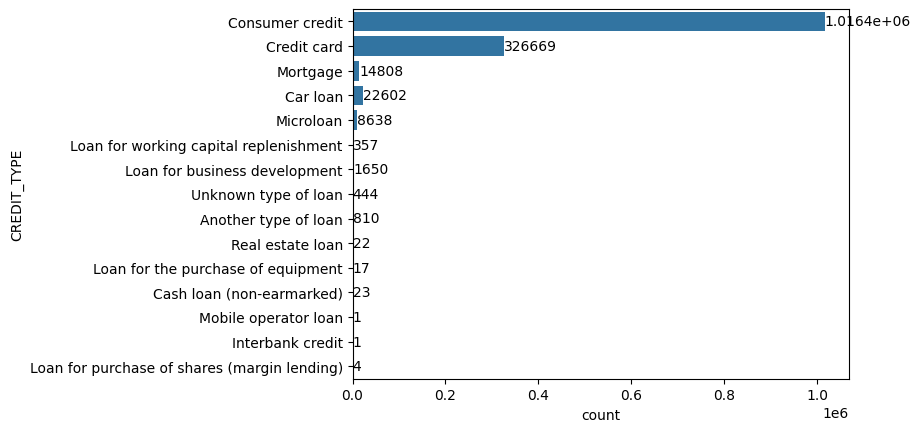

In [ ]:
sns.countplot(df.fillna("None"), y="CREDIT_TYPE")
functions.add_labels()

Aggregate count of unique types, bin into 7 categories and count for each

DAYS_CREDIT_UPDATE
False    1.0
Name: proportion, dtype: float64

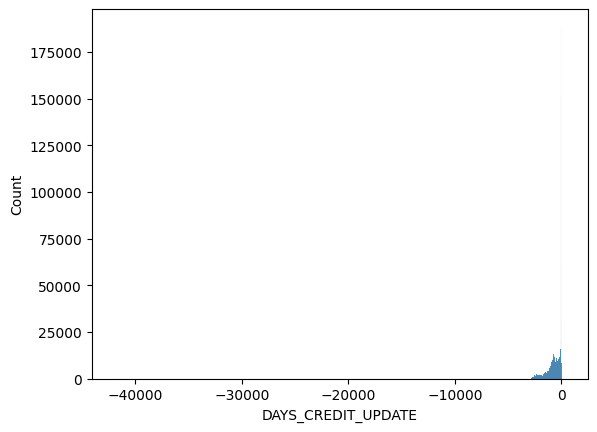

In [49]:
sns.histplot(df["DAYS_CREDIT_UPDATE"])
df["DAYS_CREDIT_UPDATE"].isna().value_counts(normalize=True)

drop, doesn't seem to be helpful

STATUS_last
True     0.807917
False    0.192083
Name: proportion, dtype: float64

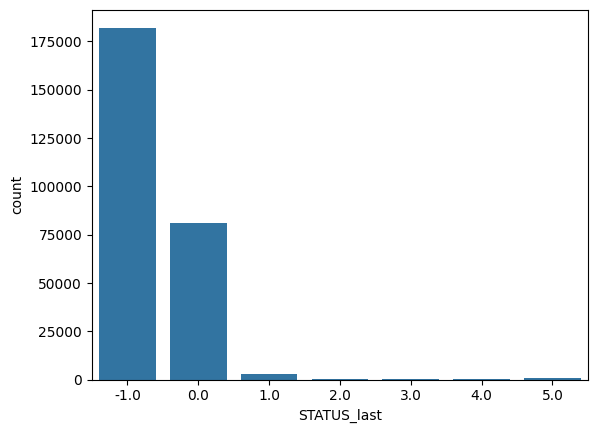

In [41]:
sns.countplot(df, x="STATUS_last")
df["STATUS_last"].isna().value_counts(normalize=True)

most are nan and mostly covered by other columns either way, so drop.

STATUS_mean
True     0.688542
False    0.311458
Name: proportion, dtype: float64

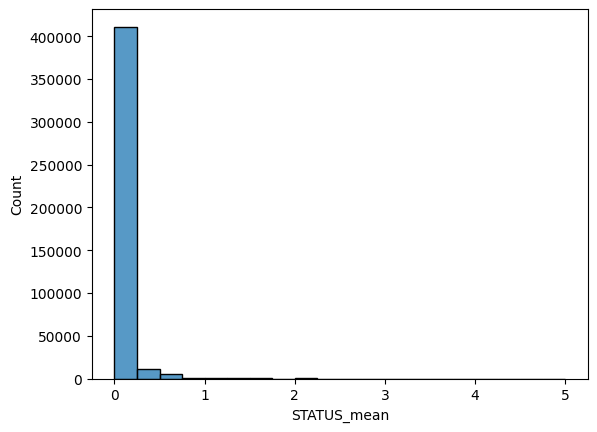

In [37]:
sns.histplot(df, x="STATUS_mean")
df["STATUS_mean"].isna().value_counts(normalize=True)

STATUS_std
True     0.706226
False    0.293774
Name: proportion, dtype: float64

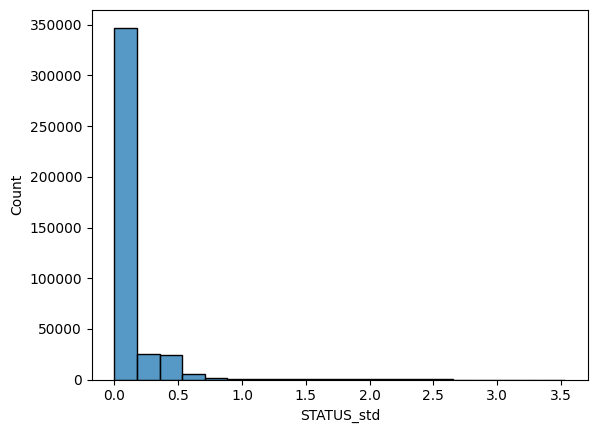

In [42]:
sns.histplot(df, x="STATUS_std")
df["STATUS_std"].isna().value_counts(normalize=True)

STATUS_max
True     0.688542
False    0.311458
Name: proportion, dtype: float64

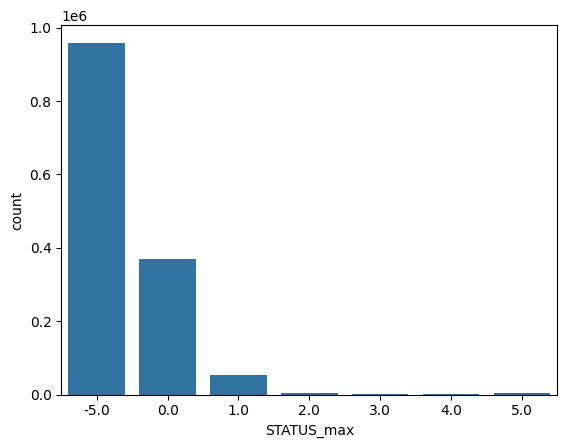

In [43]:
sns.countplot(df, x="STATUS_max")
df["STATUS_max"].isna().value_counts(normalize=True)

After merging bureau balance aggregations with the main bureau table, we can see that the proportion of missing values increased dramatically. They may no longer be usable due to the amount of missing values, but we'll see later. For max let's aggregate a max, for std and mean - means.

#### Aggregate the Table

In [5]:
aggregates_bur = functions.aggregate_bur(df)

In [6]:
aggregates_bur.to_parquet("data/train/aggregates_bur.parquet")

#### Explore the Aggregates

In [90]:
aggregates_bur.iloc[:5, :6]

,BUR_CREDIT_CURRENCY_nunique,BUR_DAYS_CREDIT_min,BUR_DAYS_CREDIT_mean,BUR_AMT_CREDIT_SUM_mean,BUR_AMT_CREDIT_SUM_max,BUR_AMT_CREDIT_SUM_DEBT_mean
SK_ID_CURR,,,,,,
100002,1,-1437,-874.000000,108131.945625,450000.0,49156.200000
100003,1,-2586,-1400.750000,254350.125000,810000.0,0.000000
100007,1,-1149,-1149.000000,146250.000000,146250.0,0.000000
100008,1,-1097,-757.333333,156148.500000,267606.0,80019.000000
100009,1,-2882,-1271.500000,266711.750000,1777500.0,76953.535714


In [91]:
aggregates_bur.iloc[:5, 6:11]

,BUR_AMT_CREDIT_SUM_DEBT_max,BUR_AMT_CREDIT_SUM_LIMIT_mean,BUR_AMT_CREDIT_SUM_LIMIT_max,BUR_AMT_CREDIT_SUM_OVERDUE_mean,BUR_AMT_CREDIT_SUM_OVERDUE_max
SK_ID_CURR,,,,,
100002,245781.0,7997.14125,31988.565,0.0,0.0
100003,0.0,202500.00000,810000.000,0.0,0.0
100007,0.0,0.00000,0.000,0.0,0.0
100008,240057.0,0.00000,0.000,0.0,0.0
100009,557959.5,0.00000,0.000,0.0,0.0


In [92]:
aggregates_bur.iloc[:5, 11:18]

,BUR_CREDIT_TYPE_nunique,BUR_AMT_ANNUITY_mean,BUR_AMT_ANNUITY_max,BUR_STATUS_mean_mean,BUR_STATUS_std_mean,BUR_STATUS_max_mean,BUR_CREDIT_ACTIVE_Closed_sum
SK_ID_CURR,,,,,,,
100002,2,0.0,0.0,0.341806,0.361962,0.75,6.0
100003,2,NaN,NaN,NaN,NaN,NaN,3.0
100007,1,NaN,NaN,NaN,NaN,NaN,1.0
100008,1,NaN,NaN,NaN,NaN,NaN,2.0
100009,2,NaN,NaN,NaN,NaN,NaN,14.0


In [93]:
aggregates_bur.iloc[:5, 18:24]

,BUR_CREDIT_ACTIVE_Active_sum,BUR_CREDIT_ACTIVE_Sold_sum,BUR_CREDIT_ACTIVE_Bad_debt_sum,BUR_Has_overdue_sum,BUR_Has_prolong_sum,BUR_CREDIT_TYPE_Consumer_credit_sum
SK_ID_CURR,,,,,,
100002,2.0,0.0,0.0,0,0,4.0
100003,1.0,0.0,0.0,0,0,2.0
100007,0.0,0.0,0.0,0,0,1.0
100008,1.0,0.0,0.0,0,0,3.0
100009,4.0,0.0,0.0,0,0,16.0


In [97]:
aggregates_bur.iloc[:5, 24:28]

,BUR_CREDIT_TYPE_Credit_card_sum,BUR_CREDIT_TYPE_Mortgage_sum,BUR_CREDIT_TYPE_Car_loan_sum,BUR_CREDIT_TYPE_Microloan_sum
SK_ID_CURR,,,,
100002,4.0,0.0,0.0,0.0
100003,2.0,0.0,0.0,0.0
100007,0.0,0.0,0.0,0.0
100008,0.0,0.0,0.0,0.0
100009,2.0,0.0,0.0,0.0


In [95]:
aggregates_bur.iloc[:5, 28:]

,BUR_CREDIT_TYPE_business_sum,BUR_CREDIT_TYPE_infrequent_sum,BUR_DAYS_CREDIT_ENDDATE_mean,BUR_DAYS_CREDIT_ENDDATE_max
SK_ID_CURR,,,,
100002,0.0,0.0,309.000000,780.0
100003,0.0,0.0,1216.000000,1216.0
100007,0.0,0.0,NaN,NaN
100008,0.0,0.0,471.000000,471.0
100009,0.0,0.0,861.666667,1402.0


### Aggregating df_cash

#### Explore the Table

In [29]:
curr_ids = df_app["SK_ID_CURR"]
prev_ids = df_prev_app[df_prev_app["SK_ID_CURR"].isin(curr_ids)]["SK_ID_PREV"]
df_cash_not_in_prev = df_cash[~df_cash["SK_ID_PREV"].isin(prev_ids)]
df_cash_not_in_prev.sample(6, random_state=42)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2768890,1855444,221561,-95,5.0,0.0,Active,0,0
3187130,2253548,191715,-95,4.0,0.0,Active,0,0
3873066,2359979,317423,-95,10.0,7.0,Active,0,0
3625383,2305306,142249,-89,8.0,0.0,Active,0,0
2859400,2103578,420492,-94,4.0,0.0,Active,11,0
9696333,2524591,148154,-51,6.0,0.0,Demand,1742,1712


As seen previously, the tables relating to previous loan applications seem to have some missing applications, but look valid otherwise.

To handle the df_cash, df_inst, df_cred tables I will take the approach to aggregate by SK_ID_CURR rather than SK_ID_PREV as it skips an aggregation step. Also, we'll be able to also handle the data with missing applications this way.

In [38]:
df_cash[df_cash["SK_ID_CURR"] == curr_ids[3]].sort_values(
    ["SK_ID_PREV", "MONTHS_BALANCE"], ascending=False
)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9595258,2299329,100006,-13,5.0,0.0,Completed,0,0
1547042,2299329,100006,-14,5.0,0.0,Active,0,0
7813685,2299329,100006,-15,12.0,8.0,Active,0,0
3226333,2299329,100006,-16,12.0,9.0,Active,0,0
6415578,2299329,100006,-17,12.0,10.0,Active,0,0
1632814,2299329,100006,-18,12.0,11.0,Active,0,0
2084324,2299329,100006,-19,12.0,12.0,Active,0,0
2692043,2299329,100006,-20,NaN,NaN,Returned to the store,0,0
6935403,2190416,100006,-1,12.0,3.0,Active,0,0
9549306,2190416,100006,-2,12.0,4.0,Active,0,0


In [39]:
df_cash.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,8.117603e+06,8.117603e+06,8.117603e+06,8.096843e+06,8.096837e+06,8.117603e+06,8.117603e+06
mean,1.903733e+06,2.785095e+05,-3.493884e+01,1.703583e+01,1.047059e+01,1.184859e+01,6.076262e-01
std,5.359788e+05,1.027539e+05,2.605221e+01,1.200428e+01,1.114546e+01,1.335114e+02,3.118360e+01
min,1.000001e+06,1.000020e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434433e+06,1.895580e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.897263e+06,2.788090e+05,-2.700000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.369345e+06,3.674820e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,8.400000e+01,8.400000e+01,4.050000e+03,3.373000e+03


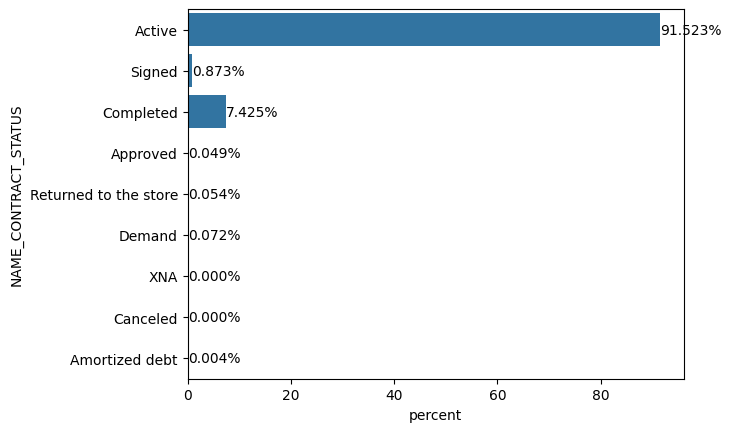

In [43]:
sns.countplot(df_cash, y="NAME_CONTRACT_STATUS", stat="percent")
functions.add_labels(fmt="%2.3f%%")

<Axes: xlabel='SK_DPD', ylabel='Count'>

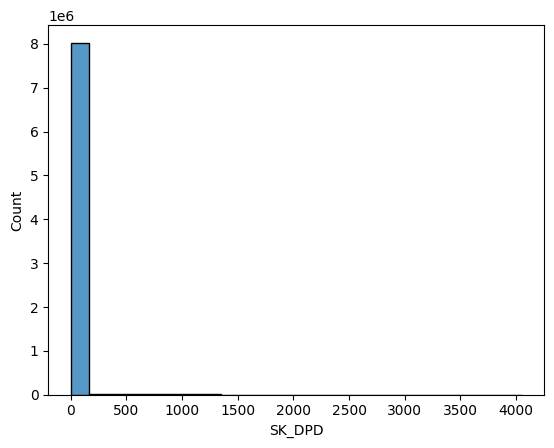

In [47]:
sns.histplot(df_cash["SK_DPD"])

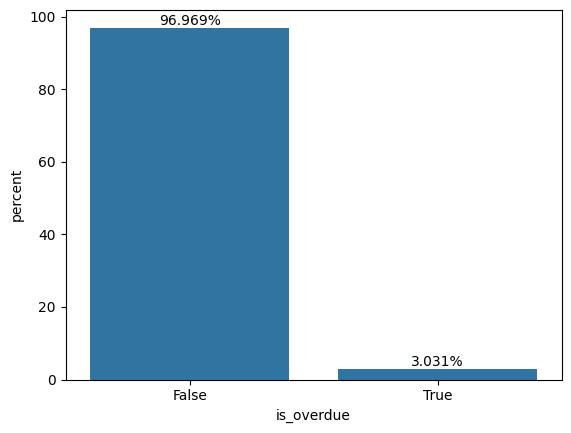

In [52]:
df_overdue = df_cash[["SK_DPD", "SK_DPD_DEF"]].copy()
df_overdue["is_overdue"] = df_overdue["SK_DPD"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue", stat="percent")
functions.add_labels(fmt="%2.2f%%")

<Axes: xlabel='SK_DPD_DEF', ylabel='Count'>

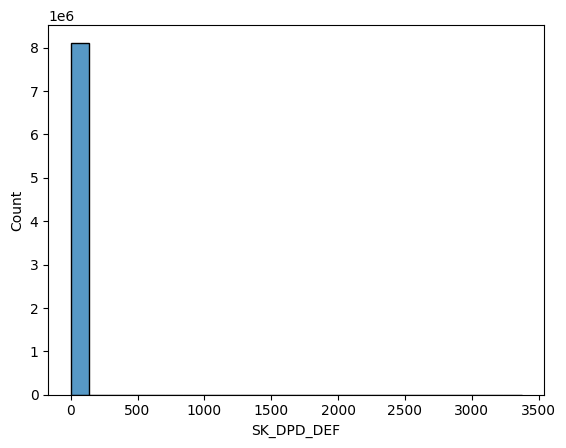

In [46]:
sns.histplot(df_cash["SK_DPD_DEF"])

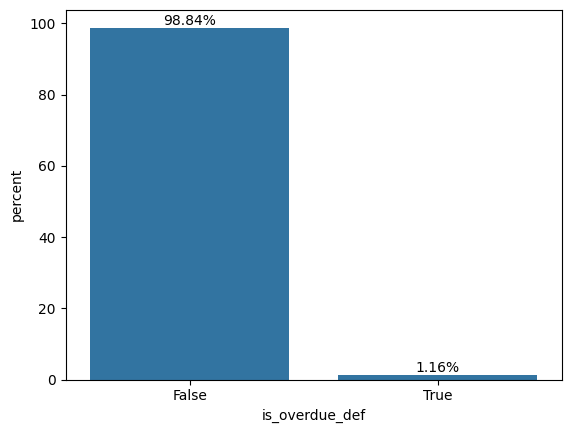

In [54]:
df_overdue["is_overdue_def"] = df_overdue["SK_DPD_DEF"] > 0
sns.countplot(df_overdue.fillna("NONE"), x="is_overdue_def", stat="percent")
functions.add_labels(fmt="%2.2f%%")

Aggregations: count unique SK_ID_PREV, count active loans, overdue count sum max, installment max

#### Aggregate the Table

In [7]:
aggregates_cash = functions.aggregate_cash(df_cash)

#### Explore Aggregations

In [22]:
aggregates_cash.iloc[:5, :5]

,CASH_SK_ID_PREV_nunique,CASH_SK_ID_PREV_count,CASH_CNT_INSTALMENT_max,CASH_SK_DPD_mean,CASH_SK_DPD_max
SK_ID_CURR,,,,,
100002,1,19,24.0,0.000000,0
100003,3,28,12.0,0.000000,0
100006,3,21,48.0,0.000000,0
100007,5,66,24.0,0.000000,0
100008,4,83,30.0,339.060241,1294


In [23]:
aggregates_cash.iloc[:5, 5:]

,CASH_Has_overdue_sum,CASH_SK_DPD_DEF_mean,CASH_SK_DPD_DEF_max,CASH_Has_overdue_def_sum,CASH_Status_Active_count
SK_ID_CURR,,,,,
100002,0,0.0,0,0,1.0
100003,0,0.0,0,0,NaN
100006,0,0.0,0,0,1.0
100007,0,0.0,0,0,1.0
100008,43,0.0,0,0,NaN


In [24]:
aggregates_cash["CASH_Status_Active_count"].describe()

count    61394.000000
mean         1.163404
std          0.411320
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: CASH_Status_Active_count, dtype: float64

good question - how to handle NAs in aggregations? ie for Status_Active_count feature, the aggregations that have NaN actually should have "0", but later when we merge with the main table new NAs will appear because they never had a previous loan with Home Credit company.

### Aggregating df_inst Table

#### Explore the Table

In [109]:
df_inst.sample(5, random_state=42)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
7186341,2478179,202625,1.0,1,-2435.0,-2443.0,4138.740,4138.740
6355399,2510003,281760,1.0,16,-84.0,-94.0,57330.000,57330.000
2587091,2805701,117190,1.0,9,-1010.0,-1020.0,23055.750,23055.750
1569197,1983707,159755,0.0,53,-1264.0,-1264.0,31.905,31.905
7971186,1964279,386486,0.0,58,-295.0,-299.0,18235.575,18235.575


In [114]:
df_inst[df_inst["SK_ID_CURR"] == curr_ids[3]].sort_values(
    ["SK_ID_PREV", "NUM_INSTALMENT_NUMBER"], ascending=False
)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
1022507,2299329,100006,2.0,5,-425.0,-438.0,15159.645,15159.645
1229699,2299329,100006,1.0,4,-455.0,-530.0,2482.920,2482.920
529435,2299329,100006,1.0,3,-485.0,-562.0,2482.920,2482.920
3314736,2299329,100006,1.0,2,-515.0,-562.0,2482.920,2482.920
2286726,2299329,100006,1.0,1,-545.0,-575.0,2482.920,2482.920
2574414,2190416,100006,1.0,10,-11.0,-12.0,29027.520,29027.520
3615701,2190416,100006,1.0,9,-41.0,-42.0,29027.520,29027.520
2388586,2190416,100006,1.0,8,-71.0,-72.0,29027.520,29027.520
218921,2190416,100006,1.0,7,-101.0,-104.0,29027.520,29027.520
670558,2190416,100006,1.0,6,-131.0,-138.0,29027.520,29027.520


In [118]:
df_inst["NUM_INSTALMENT_VERSION"].value_counts().head(10)

NUM_INSTALMENT_VERSION
1.0    6903773
0.0    3288518
2.0     498167
3.0     184775
4.0      42806
5.0      37340
6.0      13211
7.0      12727
9.0       6253
8.0       5990
Name: count, dtype: int64

Too many different variants to aggregate.

aggregations: create (days_installment - days_entry_payment) feature, take mean max min; amt - mean max.

#### Aggregate the Table

In [8]:
aggregates_inst = functions.aggregate_inst(df_inst)

### Aggregating df_cred Table

#### Explore the Table

In [171]:
good_sample_id = df_cred.dropna()["SK_ID_CURR"].sample(1, random_state=49)
good_sample = df_cred[df_cred["SK_ID_CURR"] == good_sample_id.values[0]]
good_sample = good_sample.sort_values("MONTHS_BALANCE", ascending=False)
display(good_sample.iloc[:3, :7])
good_sample.iloc[-3:, :7]

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT
3802026,2248472,455333,-2,0.0,0,0.0,0.0
2675024,2248472,455333,-3,0.0,0,0.0,0.0
75645,2248472,455333,-4,0.0,0,0.0,0.0


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT
1134179,2248472,455333,-32,113865.480,112500,0.0,0.0
1764928,2248472,455333,-33,122324.310,112500,0.0,0.0
1656899,2248472,455333,-34,118925.955,112500,112050.0,112050.0


In [174]:
display(good_sample.iloc[:3, 7:12])
good_sample.iloc[-3:, 7:12]

,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT
3802026,0.0,0.0,0.0,0.0,0.0
2675024,0.0,0.0,0.0,0.0,0.0
75645,0.0,0.0,0.0,0.0,0.0


,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT
1134179,0.0,0.0,6025.59,11970.0,6078.24
1764928,0.0,0.0,6160.50,0.0,0.00
1656899,0.0,0.0,NaN,6210.0,49.50


In [175]:
display(good_sample.iloc[:3, 12:18])
good_sample.iloc[-3:, 12:18]

,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT
3802026,0.0,0.0,0.0,0.0,0,0.0
2675024,0.0,0.0,0.0,0.0,0,0.0
75645,0.0,0.0,0.0,0.0,0,0.0


,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT
1134179,111940.2,113865.480,113865.480,0.0,0,0.0
1764928,112050.0,122324.310,122324.310,0.0,0,0.0
1656899,112050.0,114371.955,114371.955,8.0,8,0.0


In [176]:
display(good_sample.iloc[:3, 18:])
good_sample.iloc[-3:, 18:]

,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3802026,0.0,20.0,Completed,0,0
2675024,0.0,20.0,Completed,0,0
75645,0.0,20.0,Completed,0,0


,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1134179,0.0,2.0,Active,0,0
1764928,0.0,1.0,Active,0,0
1656899,0.0,NaN,Active,0,0


In [197]:
df_cred["SK_DPD"].describe()

count    3.067338e+06
mean     9.542091e+00
std      9.832393e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.831000e+03
Name: SK_DPD, dtype: float64

#### Aggregate the Table

In [24]:
aggregates_cred = functions.aggregate_cred(df_cred)

### Aggregating df_prev_app Table

#### Explore the Table

In [13]:
df_prev_app.groupby("SK_ID_CURR")["DAYS_DECISION"].max().describe()

count    276550.000000
mean       -480.351991
std         539.931545
min       -2922.000000
25%        -595.000000
50%        -299.000000
75%        -147.000000
max          -1.000000
Name: DAYS_DECISION, dtype: float64

#### Aggregate the Table

### WIP

In [26]:
aggregates = (
    aggregates_bur.join(aggregates_cash).join(aggregates_cred).join(aggregates_inst)
)

In [28]:
df_app_agg = df_app.join(aggregates, on="SK_ID_CURR")

TODO create flags for IDs that have no data in each table

In [36]:
df_app_agg.shape

(292135, 217)

In [39]:
bur_ids = aggregates_bur.index
not_in_bur_mask = ~df_app_agg["SK_ID_CURR"].isin(bur_ids)
not_in_bur_df = df_app_agg[not_in_bur_mask]
not_in_bur_df.shape

(41860, 217)

In [40]:
cash_ids = aggregates_cash.index
not_in_cash_mask = ~df_app_agg["SK_ID_CURR"].isin(cash_ids)
not_in_cash_df = df_app_agg[not_in_cash_mask]
not_in_cash_df.shape

(17108, 217)

In [32]:
df_app_agg

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CRED_CNT_DRAWINGS_POS_CURRENT_mean,CRED_CNT_DRAWINGS_POS_CURRENT_max,CRED_Status_Active_count,INST_Days_till_deadline_mean,INST_Days_till_deadline_max,INST_Days_till_deadline_min,INST_Amt_deficit_mean,INST_Amt_deficit_max,INST_AMT_INSTALMENT_mean,INST_AMT_INSTALMENT_max
47905,155481,0,Cash loans,M,N,Y,1,135000.0,678456.0,18787.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170935,298097,0,Cash loans,M,Y,Y,1,1575000.0,3299688.0,170986.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261796,403052,0,Cash loans,F,N,Y,0,67500.0,101880.0,5976.0,...,0.0,0.0,NaN,10.847458,31.0,-11.0,-265.704407,0.00,7280.747161,147888.450
291903,438168,0,Cash loans,F,Y,Y,0,270000.0,1288350.0,37800.0,...,NaN,NaN,NaN,14.053571,26.0,2.0,0.000000,0.00,13145.927143,56461.680
301036,448758,0,Cash loans,F,N,Y,0,225000.0,398016.0,20349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,239009,0,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259178,399937,0,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,...,NaN,NaN,NaN,7.761905,17.0,1.0,0.000000,0.00,44948.995714,321254.100
131932,253016,0,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,...,NaN,NaN,NaN,14.625000,69.0,-4.0,973.839375,15567.93,17822.370937,74639.655
146867,270275,0,Revolving loans,M,Y,Y,1,180000.0,270000.0,13500.0,...,2.5,8.0,NaN,25.608696,95.0,0.0,0.000000,0.00,15862.560652,85500.000


IDEA for improvement: use more last statuses, especially from those tables that have monthly updates. According to this article (https://medium.com/cuenex/credit-default-prediction-practical-tips-for-successful-execution-f62a92ab5df8), "the last aggregated features are the most important features which represent the most recent statement status and are the strongest indicator of their default risk"